Уважаемый проверяющий,
Мне не удалось реализовать усложненную модель в указанные сроки. То ядро падает, то результат получается кривой. 
Обязуюсь доделать и прислать повторно на ревью. 
Слезно прошу проверить логику и ход мысли по текущему прогрессу и направить на путь истинный. 

### Персонализированная рекомендательная модель для ритейла. 
**на базе датасета Dunnhumby - The Complete Journey.** 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

#### Этап 1 - загрузка и предобработка данных.

In [42]:
### Загрузка данных 
directory = "/Users/new/Desktop/mfdp/data/"
try:
    campaign_desc = pd.read_csv(directory + "campaign_desc.csv")
    campaign_table = pd.read_csv(directory + "campaign_table.csv")
    causal_data = pd.read_csv(directory + "causal_data.csv")
    coupon_redempt = pd.read_csv(directory + "coupon_redempt.csv")
    coupon = pd.read_csv(directory + "coupon.csv")
    hh_demographic = pd.read_csv(directory + "hh_demographic.csv")
    product = pd.read_csv(directory + "product.csv")
    transaction_data = pd.read_csv(directory + "transaction_data.csv")
    print("Все файлы успешно загружены.")
except FileNotFoundError as e:
    print(
        f"Ошибка: Не удалось найти файл {e.filename}."
    )
    exit()

Все файлы успешно загружены.


In [43]:
# Объединение данных
# 1. transaction_data + product
combined_data = pd.merge(transaction_data, product, on="PRODUCT_ID", how="left")

# 2. combined_data + hh_demographic
combined_data = pd.merge(combined_data, hh_demographic, on="household_key", how="left")

# 3. combined_data + campaign_table
combined_data = pd.merge(combined_data, campaign_table, on="household_key", how="left")

# 4. combined_data + campaign_desc
combined_data = pd.merge(combined_data, campaign_desc, on="CAMPAIGN", how="left")

# 5. combined_data + coupon
combined_data = pd.merge(
    combined_data, coupon, on=["PRODUCT_ID", "CAMPAIGN"], how="left"
)

# 6. combined_data + coupon_redempt
combined_data = pd.merge(
    combined_data,
    coupon_redempt,
    on=["household_key", "DAY", "COUPON_UPC", "CAMPAIGN"],
    how="left",
)

# 7. causal_data - сложное объединение, требуется предобработка
# Преобразуем WEEK_NO в DAY, чтобы можно было объединить с combined_data
causal_data["DAY"] = (
    causal_data["WEEK_NO"] - 1
) * 7 + 1 

# Объединяем causal_data с combined_data по PRODUCT_ID, STORE_ID и DAY
combined_data = pd.merge(
    combined_data, causal_data, on=["PRODUCT_ID", "STORE_ID", "DAY"], how="left"
)


In [44]:
### Предобработка данных
### Функция на проверку пропусков и дубликатов + их обработка
def preprocess_data(df):
    num_null = df.isnull().sum().sum()
    num_duplicates = df.duplicated().sum()

    if num_null > 0 or num_duplicates > 0:
        print(f"Проверка данных:")
        print(f" Количество пропусков до обработки:\n{df.isnull().sum()}")
        print(f" Количество дубликатов до обработки: {df.duplicated().sum()}")

        # Заполнение пропусков (заполняем 'Unknown' для категориальных признаков и 0 для числовых)
        for col in df.columns:
            if df[col].dtype == "object":
                df[col] = df[col].fillna("Unknown")
            else:
                df[col] = df[col].fillna(0)

        if num_duplicates > 0:
            print(f"Удаление дубликатов...")
            df.drop_duplicates(inplace=True)

        print(f"  Количество пропусков после обработки:\n{df.isnull().sum()}")
        print(f"  Количество дубликатов после обработки: {df.duplicated().sum()}")

    else:
        print(f"Пропуски и дубликаты не найдены.")


In [45]:
### Запускаем функцию
preprocess_data(combined_data)

Проверка данных:
 Количество пропусков до обработки:
household_key                  0
BASKET_ID                      0
DAY                            0
PRODUCT_ID                     0
QUANTITY                       0
SALES_VALUE                    0
STORE_ID                       0
RETAIL_DISC                    0
TRANS_TIME                     0
WEEK_NO_x                      0
COUPON_DISC                    0
COUPON_MATCH_DISC              0
MANUFACTURER                   0
DEPARTMENT                     0
BRAND                          0
COMMODITY_DESC                 0
SUB_COMMODITY_DESC             0
CURR_SIZE_OF_PRODUCT           0
AGE_DESC                 4966176
MARITAL_STATUS_CODE      4966176
INCOME_DESC              4966176
HOMEOWNER_DESC           4966176
HH_COMP_DESC             4966176
HOUSEHOLD_SIZE_DESC      4966176
KID_CATEGORY_DESC        4966176
DESCRIPTION_x             303827
CAMPAIGN                  303827
DESCRIPTION_y             303827
START_DAY              

In [46]:
combined_data["PRODUCT_ID"] = combined_data["PRODUCT_ID"].astype(int)


In [47]:
combined_data["DAY_OF_WEEK"] = (
    combined_data["DAY"] % 7
) + 1  # Предполагаем, что 1 - понедельник, 7 - воскресенье


In [48]:
combined_data = combined_data.drop(['WEEK_NO_y', 'display', 'mailer'], axis=1)

##### Этап 2 - анализ данных.

In [49]:
### Что из себя представляет dataframe
print(combined_data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 14546283 entries, 0 to 14576304
Data columns (total 32 columns):
 #   Column                Dtype  
---  ------                -----  
 0   household_key         int64  
 1   BASKET_ID             int64  
 2   DAY                   int64  
 3   PRODUCT_ID            int64  
 4   QUANTITY              int64  
 5   SALES_VALUE           float64
 6   STORE_ID              int64  
 7   RETAIL_DISC           float64
 8   TRANS_TIME            int64  
 9   WEEK_NO_x             int64  
 10  COUPON_DISC           float64
 11  COUPON_MATCH_DISC     float64
 12  MANUFACTURER          int64  
 13  DEPARTMENT            object 
 14  BRAND                 object 
 15  COMMODITY_DESC        object 
 16  SUB_COMMODITY_DESC    object 
 17  CURR_SIZE_OF_PRODUCT  object 
 18  AGE_DESC              object 
 19  MARITAL_STATUS_CODE   object 
 20  INCOME_DESC           object 
 21  HOMEOWNER_DESC        object 
 22  HH_COMP_DESC          object 
 23  HOUSEHOLD_

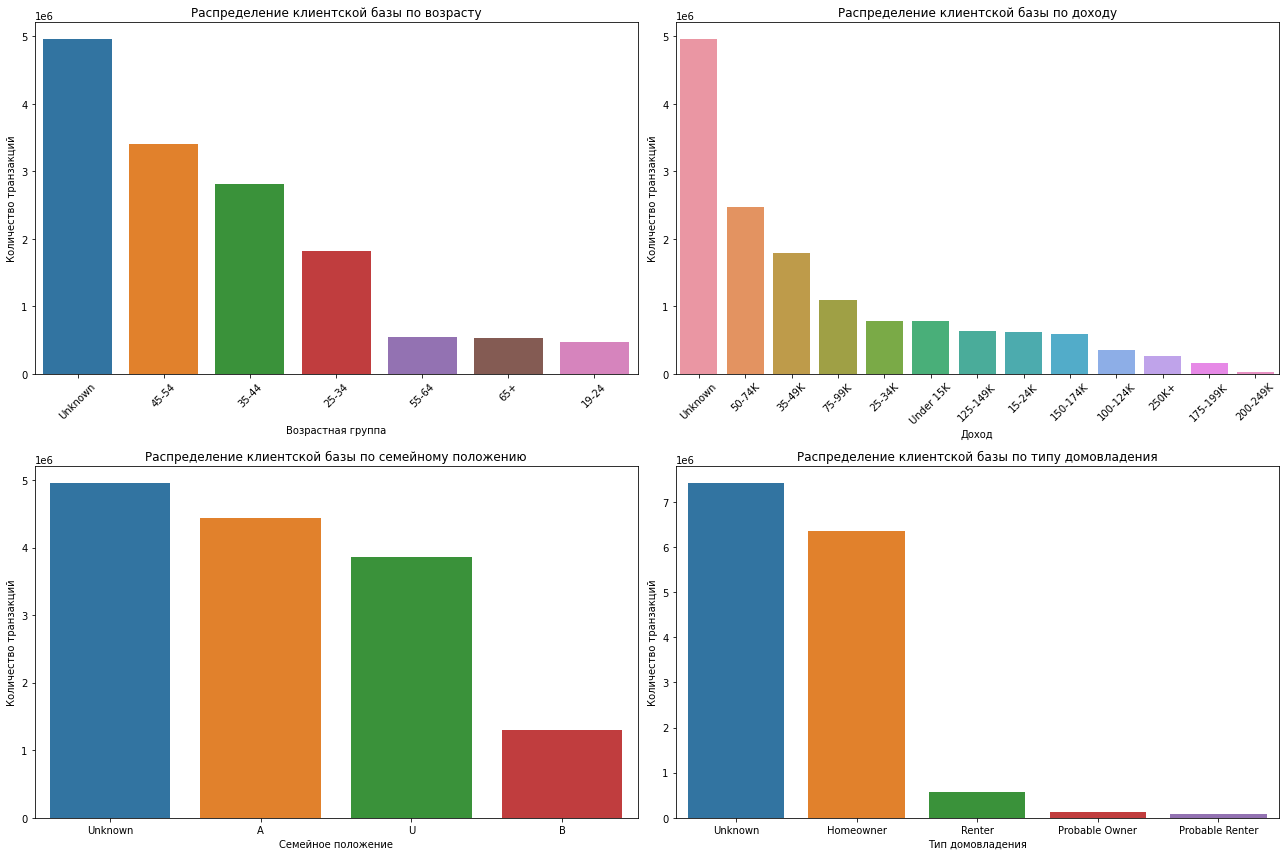

In [50]:
### Анализ клиентской базы
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Создаем сетку 2x2 для графиков
axes = axes.flatten()  # Преобразуем массив axes в одномерный

# Распределение по возрасту
sns.countplot(
    ax=axes[0],
    x="AGE_DESC",
    data=combined_data,
    order=combined_data["AGE_DESC"].value_counts().index,
)
axes[0].set_title("Распределение клиентской базы по возрасту")
axes[0].set_xlabel("Возрастная группа")
axes[0].set_ylabel("Количество транзакций")
axes[0].tick_params(axis="x", rotation=45)

# Распределение по доходу
sns.countplot(
    ax=axes[1],
    x="INCOME_DESC",
    data=combined_data,
    order=combined_data["INCOME_DESC"].value_counts().index,
)
axes[1].set_title("Распределение клиентской базы по доходу")
axes[1].set_xlabel("Доход")
axes[1].set_ylabel("Количество транзакций")
axes[1].tick_params(axis="x", rotation=45)

# Распределение по семейному положению
sns.countplot(
    ax=axes[2],
    x="MARITAL_STATUS_CODE",
    data=combined_data,
    order=combined_data["MARITAL_STATUS_CODE"].value_counts().index,
)
axes[2].set_title("Распределение клиентской базы по семейному положению")
axes[2].set_xlabel("Семейное положение")
axes[2].set_ylabel("Количество транзакций")

# Распределение по типу домовладения
sns.countplot(
    ax=axes[3],
    x="HOMEOWNER_DESC",
    data=combined_data,
    order=combined_data["HOMEOWNER_DESC"].value_counts().index,
)
axes[3].set_title("Распределение клиентской базы по типу домовладения")
axes[3].set_xlabel("Тип домовладения")
axes[3].set_ylabel("Количество транзакций")

plt.tight_layout()
plt.show()

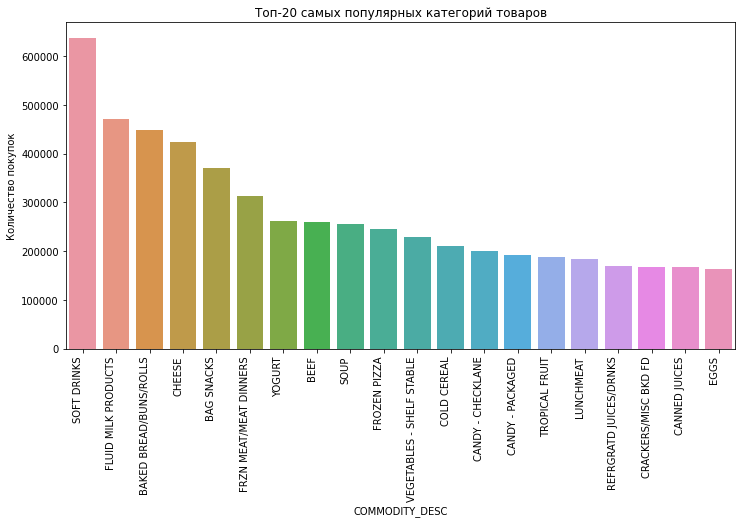

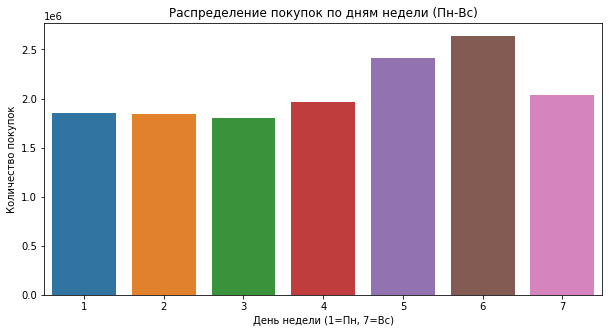

In [51]:
### Анализ покупок
# Анализ популярности категорий товаров (COMMODITY_DESC)
N = 20  # Топ-20 категорий
plt.figure(figsize=(12, 6))
sns.countplot(
    data=combined_data,
    x="COMMODITY_DESC",
    order=combined_data["COMMODITY_DESC"].value_counts().head(N).index,
)
plt.title(f"Топ-{N} самых популярных категорий товаров")
plt.xlabel("COMMODITY_DESC")
plt.ylabel("Количество покупок")
plt.xticks(rotation=90, ha="right")
plt.show()

# Анализ распределения покупок по дням недели
plt.figure(figsize=(10, 5))
sns.countplot(
    data=combined_data, x="DAY_OF_WEEK", order=[1, 2, 3, 4, 5, 6, 7]
)
plt.title("Распределение покупок по дням недели (Пн-Вс)")
plt.xlabel("День недели (1=Пн, 7=Вс)")
plt.ylabel("Количество покупок")
plt.show()

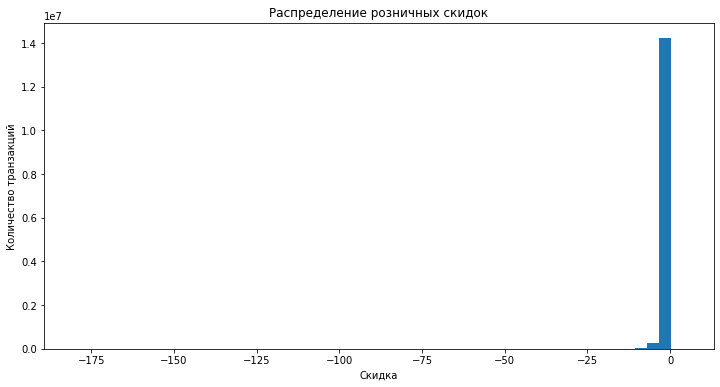

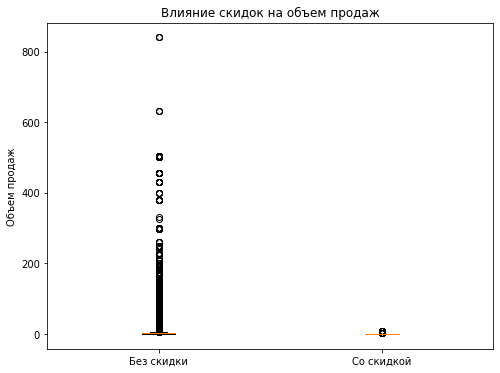

In [52]:
# Гистограмма распределения скидок
plt.figure(figsize=(12, 6))
plt.hist(combined_data["RETAIL_DISC"], bins=50)
plt.title("Распределение розничных скидок")
plt.xlabel("Скидка")
plt.ylabel("Количество транзакций")
plt.show()

# Ящик с усами для сравнения продаж со скидкой и без
plt.figure(figsize=(8, 6))
discount = combined_data["RETAIL_DISC"] > 0
plt.boxplot(
    [combined_data["SALES_VALUE"][~discount], combined_data["SALES_VALUE"][discount]],
    labels=["Без скидки", "Со скидкой"],
)
plt.title("Влияние скидок на объем продаж")
plt.ylabel("Объем продаж")
plt.show()


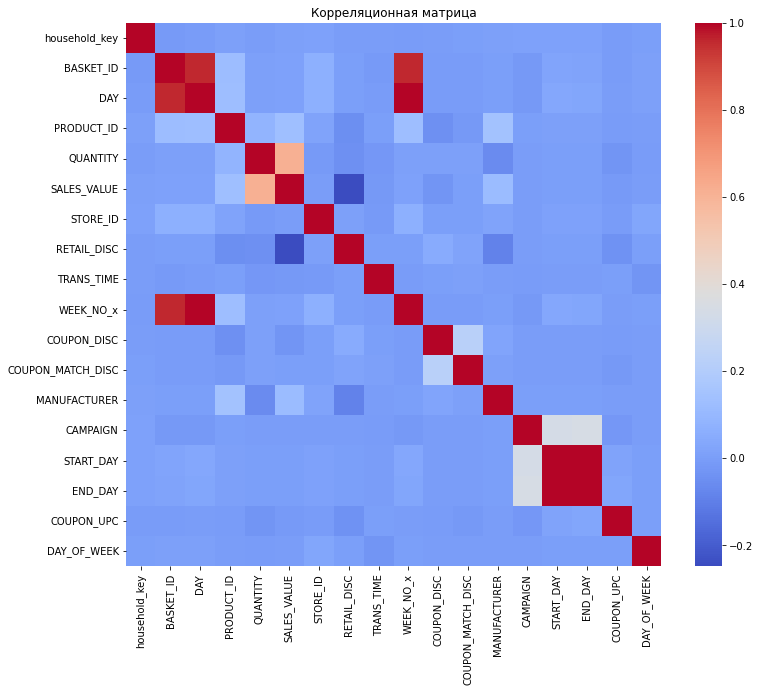

In [53]:
### Корреляции между признакми 
# Выделяем только числовые столбцы для расчета корреляции
numerical_data = combined_data.select_dtypes(include=np.number)

# Вычисляем корреляционную матрицу
corr_matrix = numerical_data.corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, annot=False, cmap="coolwarm"
) 
plt.title("Корреляционная матрица")
plt.show()

##### Этап 3 - разработка модели.

In [54]:
### Feature Engineering

# Преобразование категориальных признаков в числовые с помощью Label Encoding
categorical_features = [
    "DEPARTMENT",
    "BRAND",
    "COMMODITY_DESC",
    "SUB_COMMODITY_DESC",
    "AGE_DESC",
    "MARITAL_STATUS_CODE",
    "INCOME_DESC",
    "HOMEOWNER_DESC",
    "HH_COMP_DESC",
    "HOUSEHOLD_SIZE_DESC",
    "KID_CATEGORY_DESC",
]

for col in categorical_features:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(
        combined_data[col].astype(str)
    )

In [55]:
### Подчистим скорреклированные призаки
numerical_data = combined_data.select_dtypes(include=np.number)
corr_matrix = numerical_data.corr()
correlation_threshold = 0.8 ### Порог коррекляции

In [77]:
combined_data.head(10).to_csv('test.csv')

#### Baseline строим: SVD (Singular Value Decomposition)

In [ ]:
### SVD

### Готовим Reader
# Преобразуем SALES_VALUE в шкалу рейтинга от 1 до 5
scaler = MinMaxScaler(feature_range=(1, 5))
combined_data["RATING"] = scaler.fit_transform(combined_data[["SALES_VALUE"]])

reader = Reader(
    rating_scale=(
        combined_data["RATING"].min(),
        combined_data["RATING"].max(),
    )
)
data = Dataset.load_from_df(
    combined_data[["household_key", "PRODUCT_ID", "RATING"]], reader
)

### Делим на трейн и на тест
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Обучаем модель
n_factors = 50  # <--- Измените это значение
random_state = 42  # <--- Измените это значение
model = SVD(n_factors=n_factors, random_state=random_state)
model.fit(trainset)


### Функция предикта для конкретного юзера
def predict_for_user(user_id, model, testset):
    user_test_data = [x for x in testset if x[0] == user_id]
    predictions = model.test(user_test_data)
    return predictions


### Расчет  метрик
def calculate_metrics(user_id, predictions, combined_data, N=10):
    actual_purchases = combined_data[
        (combined_data["household_key"] == user_id)
        & (combined_data["PRODUCT_ID"].isin([x.iid for x in predictions]))
    ]["PRODUCT_ID"].unique()

    # Предсказанные рейтинги и соответствующие item_id
    predicted_ratings = np.array([pred.est for pred in predictions])
    item_ids = np.array([pred.iid for pred in predictions])

    # Индексы топ-N предсказанных товаров
    top_n_indices = np.argsort(predicted_ratings)[::-1][:N]
    top_n_items = item_ids[top_n_indices]

    # Создаем векторы ground truth и predictions для sklearn метрик
    ground_truth = np.in1d(item_ids, actual_purchases).astype(
        int
    )  # 1 если товар был куплен, 0 если нет
    predictions_binary = np.in1d(item_ids, top_n_items).astype(
        int
    )  # 1 если товар в топ-N, 0 если нет

    # Precision@K
    precision = np.sum(ground_truth[:N]) / N if len(ground_truth) > 0 else 0

    # Recall@K
    recall = (
        np.sum(ground_truth[:N]) / len(actual_purchases)
        if len(actual_purchases) > 0
        else 0
    )

    ### Метрики качества
    # Обработка случая, когда нет ни true, ни predicted samples
    if np.sum(ground_truth) == 0 and np.sum(predictions_binary) == 0:
        f1 = 0.0
    else:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(ground_truth, predictions_binary)

    return f1, precision, recall


### Оценка качества на первых 100 пользователях (для скорости)
user_ids = combined_data["household_key"].unique()[:100]

f1s = []
precisions = []
recalls = []

for user_id in user_ids:
    ### Получаем предсказания для пользователя
    predictions = predict_for_user(user_id, model, testset)

    ### Рассчитываем  метрики
    f1, precision, recall = calculate_metrics(user_id, predictions, combined_data)

    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

### Выводим средние значения метрик
print(f"Mean F1-score: {np.mean(f1s)}")
print(f"Mean Precision@10: {np.mean(precisions)}")
print(f"Mean Recall@10: {np.mean(recalls)}")

### RMSE и MAE
predictions_all = model.test(testset)

# Рассчитываем RMSE и MAE на основе преобразованных рейтингов
rmse = accuracy.rmse(predictions_all)
mae = accuracy.mae(predictions_all)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


### Функция для получения рекомендаций для пользователя
def get_recommendations(user_id, model, data, N=10):
    """
    Рекомендует N товаров для пользователя, которых он еще не покупал.
    """
    all_items = combined_data["PRODUCT_ID"].unique()
    user_items = combined_data[combined_data["household_key"] == user_id][
        "PRODUCT_ID"
    ].unique()
    items_to_predict = [item for item in all_items if item not in user_items]
    predictions = [
        (item, model.predict(user_id, item).est) for item in items_to_predict
    ]
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n_items = [item[0] for item in predictions[:N]]
    return top_n_items


### Тестирование
user_id = 2375
recommendations = get_recommendations(user_id, model, data, N=10)
print(f"Рекомендации для пользователя {user_id}: {recommendations}")


Mean F1-score: 0.15730685465741553
Mean Precision@10: 0.995
Mean Recall@10: 0.11995358813905616
RMSE: 0.0109
MAE:  0.0043
RMSE: 0.010933784413136508
MAE: 0.004311580902017748
Рекомендации для пользователя 2375: [13212959, 1089093, 13381195, 12582517, 13381271, 12673308, 13212980, 12757156, 13213177, 13040176]


#### Усложненная гибридная модель SVD с content-based filtering и оптимизацией веса alpha с помощью RandomizedSearchCV.

In [ ]:
### SVD based hybrid model 
scaler = MinMaxScaler(feature_range=(1, 5))
combined_data["RATING"] = scaler.fit_transform(combined_data[["SALES_VALUE"]])

reader = Reader(
    rating_scale=(
        combined_data["RATING"].min(),
        combined_data["RATING"].max(),
    )
)
data = Dataset.load_from_df(
    combined_data[["household_key", "PRODUCT_ID", "RATING"]], reader
)

### Делим на трейн и на тест
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Преобразуем Surprise Dataset в Pandas DataFrame
df = pd.DataFrame(
    [
        (uid, iid, rating) for (uid, iid, rating, *_) in data.raw_ratings
    ],  # Используем только uid, iid и rating
    columns=["household_key", "PRODUCT_ID", "RATING"],
)

# Подготовка данных о товарах
# Создаем текстовое описание товара на основе COMMODITY_DESC и SUB_COMMODITY_DESC
df["item_description"] = df["PRODUCT_ID"].map(
    combined_data.drop_duplicates(subset=["PRODUCT_ID"])
    .set_index("PRODUCT_ID")[["COMMODITY_DESC", "SUB_COMMODITY_DESC"]]
    .fillna("")
    .astype(str)  # Преобразуем все значения в строки
    .agg(" ".join, axis=1)
)

# Используем TF-IDF для векторизации текстовых описаний товаров
tfidf = TfidfVectorizer(
    stop_words="english", max_features=100
)  # Ограничиваем количество признаков
tfidf_matrix = tfidf.fit_transform(df["item_description"]).toarray()
item_features = pd.DataFrame(tfidf_matrix, index=df["PRODUCT_ID"])


# Гибридная модель SVD
def hybrid_svd_prediction(user_id, item_id, model, item_features, alpha=0.8):
    """Предсказывает рейтинг с использованием гибридной модели SVD."""
    try:
        # Предсказание SVD
        svd_prediction = model.predict(user_id, item_id).est

        # Content-based filtering: косинусное сходство между товарами
        item_vector = item_features.loc[item_id].values.reshape(1, -1)
        similarities = np.dot(item_features, item_vector.T)
        similar_items = np.argsort(similarities[:, 0])[::-1][
            1:6
        ]  # Топ-5 похожих товаров

        # Усредняем рейтинги похожих товаров (можно улучшить, используя взвешенное усреднение)
        similar_ratings = [
            model.predict(user_id, item).est
            for item in similar_items
            if str(item) in item_features.index
        ]
        if similar_ratings:
            content_prediction = np.mean(similar_ratings)
        else:
            content_prediction = (
                svd_prediction  # Если нет похожих товаров, используем предсказание SVD
            )

        # Взвешенное усреднение SVD и content-based предсказаний
        hybrid_prediction = alpha * svd_prediction + (1 - alpha) * content_prediction

        return hybrid_prediction

    except Exception as e:
        # print(f"Error predicting rating: {e}")
        return model.default_prediction()  # Возвращаем средний рейтинг


# Оптимизация гиперпараметров с RandomizedSearchCV
param_distributions = {"alpha": np.arange(0.6, 0.91, 0.05)}  # Вес для SVD


# Оценка качества
def calculate_metrics(user_id, model, item_features, alpha, N=10):
    """Рассчитывает метрики для пользователя."""
    # Получаем список всех товаров
    all_items = combined_data["PRODUCT_ID"].unique()
    # Получаем список товаров, которые пользователь уже покупал
    user_items = combined_data[combined_data["household_key"] == user_id][
        "PRODUCT_ID"
    ].unique()
    # Исключаем купленные товары из списка кандидатов на рекомендации
    items_to_predict = [item for item in all_items if item not in user_items]

    # Создаем список кортежей (item_id, predicted_rating)
    predictions = [
        (item, hybrid_svd_prediction(user_id, item, model, item_features, alpha))
        for item in items_to_predict
    ]

    # Сортируем товары по убыванию predicted_rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Берем топ-N товаров
    top_n_items = [item[0] for item in predictions[:N]]

    # Получаем список фактически купленных товаров
    actual_purchases = combined_data[(combined_data["household_key"] == user_id)][
        "PRODUCT_ID"
    ].unique()

    # Создаем векторы ground truth и predictions для sklearn метрик
    ground_truth = np.in1d(top_n_items, actual_purchases).astype(
        int
    )  # 1 если товар был куплен, 0 если нет
    # predictions_binary = np.ones(len(top_n_items), dtype=int)  # Все рекомендованные товары считаем "предсказанными"
    predictions_binary = np.in1d(item_ids, top_n_items).astype(int)

    # Precision@K
    precision = np.sum(ground_truth) / N if N > 0 else 0

    # Recall@K
    recall = (
        np.sum(ground_truth) / len(actual_purchases) if len(actual_purchases) > 0 else 0
    )

    # Вычисляем F1-score
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        # f1 = f1_score(ground_truth, predictions_binary[: len(ground_truth)])  # Обрезаем predictions_binary до длины ground_truth
        f1 = f1_score(ground_truth, predictions_binary[:N])

    return f1, precision, recall


# Обучение и оценка модели
n_iterations = 10  # Количество итераций для RandomizedSearchCV
best_f1 = -1
best_alpha = 0

# Создаем и обучаем модель SVD
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)

for i in range(n_iterations):
    # Случайный выбор alpha
    alpha = np.random.uniform(0.6, 0.9)

    # Оцениваем модель на нескольких пользователях
    user_ids = combined_data["household_key"].unique()[
        :100
    ]  # Оцениваем на первых 100 пользователях

    f1_scores = []
    precisions = []
    recalls = []

    for user_id in user_ids:
        f1, precision, recall = calculate_metrics(user_id, model, item_features, alpha)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)

    mean_f1 = np.mean(f1_scores)

    # Если текущая модель лучше, чем лучшая предыдущая, сохраняем ее
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_alpha = alpha

    print(f"Iteration {i + 1}: alpha = {alpha:.2f}, Mean F1-score = {mean_f1:.4f}")

print(f"Best alpha: {best_alpha:.2f}, Best Mean F1-score: {best_f1:.4f}")

# 6. Выводим результаты
print(f"Best alpha: {best_alpha:.2f}")

# Рассчитываем метрики с лучшим alpha
f1_scores = []
precisions = []
recalls = []

for user_id in user_ids:
    f1, precision, recall = calculate_metrics(user_id, model, item_features, best_alpha)
    f1_scores.append(f1)

    precisions.append(precision)
    recalls.append(recall)

print(f"Mean F1-score: {np.mean(f1_scores)}")
print(f"Mean Precision@10: {np.mean(precisions)}")
print(f"Mean Recall@10: {np.mean(recalls)}")


### Функция для получения рекомендаций для пользователя
def get_recommendations(user_id, model, item_features, alpha, N=10):
    """
    Рекомендует N товаров для пользователя, которых он еще не покупал.
    """
    all_items = combined_data["PRODUCT_ID"].unique()
    user_items = combined_data[combined_data["household_key"] == user_id][
        "PRODUCT_ID"
    ].unique()
    items_to_predict = [item for item in all_items if item not in user_items]
    predictions = [
        (item, hybrid_svd_prediction(user_id, item, model, item_features, alpha))
        for item in items_to_predict
    ]
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n_items = [item[0] for item in predictions[:N]]
    return top_n_items


### Тестирование
user_id = 2375
recommendations = get_recommendations(user_id, model, item_features, best_alpha, N=10)
print(f"Рекомендации для пользователя {user_id}: {recommendations}")


KeyboardInterrupt: 